# Bayesian methods: quantifying cause and effect

# Imports

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import numpy.random as rnd

In [39]:
import os
plt.style.use(os.path.join(os.getcwd(), 'mystyle.mplstyle') )

# US Air travel saftey record

## Getting the NTSB data

In [40]:
from datetime import datetime

In [41]:
aadata = pd.read_csv('data/AviationData.txt', 
                     delimiter='|', 
                     skiprows=1,
                    names=['id', 'type', 'number', 'date',
       'location', 'country', 'lat', 'long', 'airport_code',
       'airport_name', 'injury_severity', 'aircraft_damage',
       'aircraft_cat', 'reg_no', 'make', 'model',
       'amateur_built', 'no_engines', 'engine_type', 'FAR_desc',
       'schedule', 'purpose', 'air_carrier', 'fatal',
       'serious', 'minor', 'uninjured',
       'weather', 'broad_phase', 'report_status',
       'pub_date', 'none'])

In [42]:
aadata.columns

Index(['id', 'type', 'number', 'date', 'location', 'country', 'lat', 'long',
       'airport_code', 'airport_name', 'injury_severity', 'aircraft_damage',
       'aircraft_cat', 'reg_no', 'make', 'model', 'amateur_built',
       'no_engines', 'engine_type', 'FAR_desc', 'schedule', 'purpose',
       'air_carrier', 'fatal', 'serious', 'minor', 'uninjured', 'weather',
       'broad_phase', 'report_status', 'pub_date', 'none'],
      dtype='object')

In [43]:
selection = aadata['date'] != '  '
aadata = aadata[selection]

In [44]:
aadata['datetime'] = [datetime.strptime(x, ' %m/%d/%Y ') for x in aadata['date']]

In [45]:
aadata['month'] = [int(x.month) for x in aadata['datetime']]
aadata['year'] = [int(x.year) for x in aadata['datetime']]

In [46]:
def decyear(date):
    start = datetime(year=date.year, month=1, day=1)
    end = datetime(year=date.year+1, month=1, day=1)
    decimal = (date - start)/(end-start)
    return date.year+decimal

In [47]:
aadata['decyear'] = aadata['datetime'].apply(decyear)

In [48]:
cols = ['lat', 'long', 
        'fatal',
        'serious',
        'minor', 
        'uninjured']
aadata[cols] = aadata[cols].applymap(
        lambda x: np.nan if isinstance(x, str) 
                    and x.isspace() else float(x))

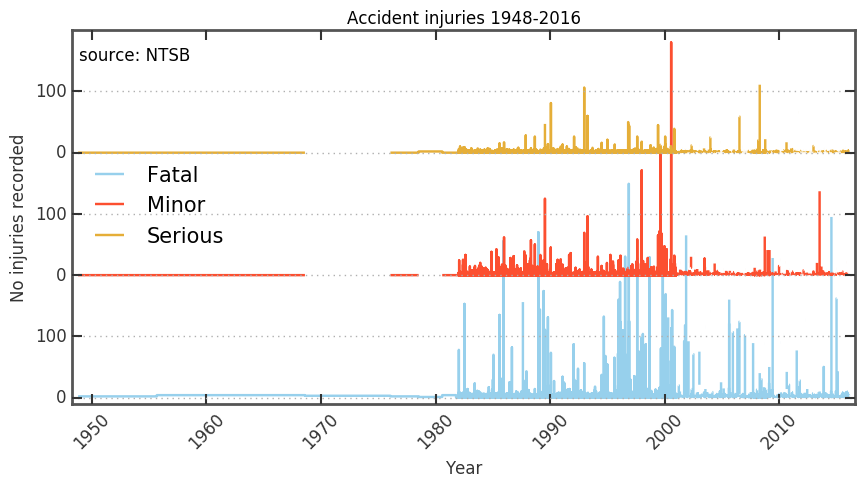

In [49]:
plt.figure(figsize=(9,4.5))
plt.step(aadata['decyear'], aadata['fatal'], 
         lw=1.75, where='mid', alpha=0.5, label='Fatal')
plt.step(aadata['decyear'], aadata['minor']+200, 
         lw=1.75,where='mid', label='Minor')
plt.step(aadata['decyear'], aadata['serious']+200*2, 
         lw=1.75, where='mid', label='Serious')
plt.xticks(rotation=45)
plt.legend(loc=(0.01,.4),fontsize=15)
plt.ylim((-10,600))
plt.grid(axis='y')
plt.title('Accident injuries {0}-{1}'.format(
            aadata['year'].min(), aadata['year'].max()))
plt.text(0.15,0.92,'source: NTSB', size=12, 
         transform=plt.gca().transAxes, ha='right')
plt.yticks(np.arange(0,600,100), [0,100,0,100,0,100])
plt.xlabel('Year')
plt.ylabel('No injuries recorded')
plt.xlim((aadata['decyear'].min()-0.5, 
          aadata['decyear'].max()+0.5));

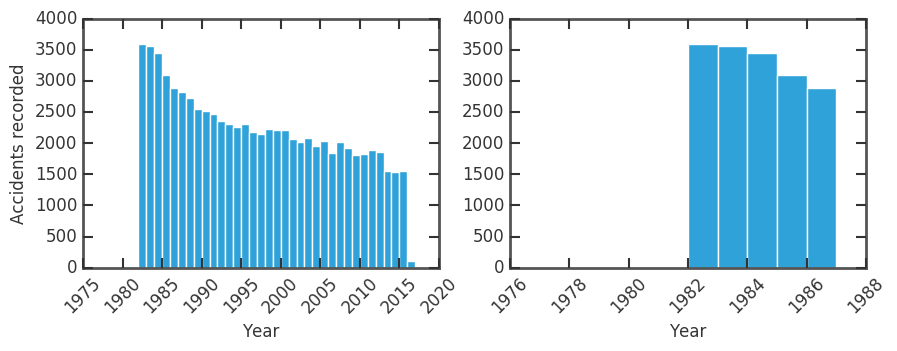

In [50]:
plt.figure(figsize=(9,3))
plt.subplot(121)
year_selection = (aadata['year']>=1975) & (aadata['year']<=2016)
plt.hist(aadata[year_selection]['year'].as_matrix(), 
         bins=np.arange(1975,2016+2,1), align='mid')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Accidents recorded')
plt.subplot(122)
year_selection = (aadata['year']>=1976) & (aadata['year']<=1986)
plt.hist(aadata[year_selection]['year'].as_matrix(), 
         bins=np.arange(1976,1986+2,1), align='mid')
plt.xlabel('Year')
plt.xticks(rotation=45);

In [51]:
aadata[aadata['year']<=1981]

,id,type,number,date,location,country,lat,long,airport_code,airport_name,...,uninjured,weather,broad_phase,report_status,pub_date,none,datetime,month,year,decyear
77960,20001218X45446,Accident,CHI81LA106,08/01/1981,"COTTON, MN",United States,NaN,NaN,,,...,0,IMC,UNKNOWN,Probable Cause,11/06/2001,,1981-08-01,8,1981,1981.580822
77961,20041105X01764,Accident,CHI79FA064,08/02/1979,"Canton, OH",United States,NaN,NaN,,,...,NaN,VMC,APPROACH,Probable Cause,04/16/1980,,1979-08-02,8,1979,1979.583562
77962,20001218X45448,Accident,LAX96LA321,06/19/1977,"EUREKA, CA",United States,NaN,NaN,,,...,0,IMC,CRUISE,Probable Cause,09/12/2000,,1977-06-19,6,1977,1977.463014
77963,20061025X01555,Accident,NYC07LA005,08/30/1974,"Saltville, VA",United States,36.922223,-81.878056,,,...,NaN,IMC,CRUISE,Probable Cause,02/26/2007,,1974-08-30,8,1974,1974.660274
77964,20001218X45447,Accident,LAX94LA336,07/19/1962,"BRIDGEPORT, CA",United States,NaN,NaN,,,...,0,UNK,UNKNOWN,Probable Cause,09/19/1996,,1962-07-19,7,1962,1962.545205
77965,20001218X45444,Accident,SEA87LA080,10/24/1948,"MOOSE CREEK, ID",United States,NaN,NaN,,,...,0,UNK,CRUISE,Probable Cause,,,1948-10-24,10,1948,1948.811475


In [52]:
aadata = aadata[ aadata['year']>1981 ]

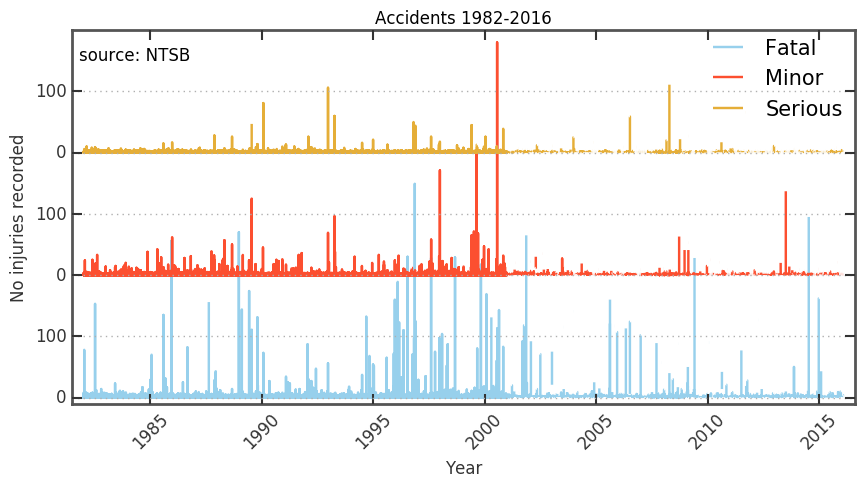

In [53]:
plt.figure(figsize=(9,4.5))
plt.step(aadata['decyear'], aadata['fatal'], 
         lw=1.75, where='mid', alpha=0.5, label='Fatal')
plt.step(aadata['decyear'], aadata['minor']+200, 
         lw=1.75,where='mid', label='Minor')
plt.step(aadata['decyear'], aadata['serious']+200*2, 
         lw=1.75, where='mid', label='Serious')
plt.xticks(rotation=45)
plt.legend(loc=(0.8,0.74),fontsize=15)
plt.ylim((-10,600))
plt.grid(axis='y')
plt.title('Accidents {0}-{1}'.format(
            aadata['year'].min(), aadata['year'].max()))
plt.text(0.15,0.92,'source: NTSB', size=12, 
         transform=plt.gca().transAxes, ha='right')
plt.yticks(np.arange(0,600,100), [0,100,0,100,0,100])
plt.xlabel('Year')
plt.ylabel('No injuries recorded')
plt.xlim((aadata['decyear'].min()-0.5, aadata['decyear'].max()+0.5));

## Binning

### Yearly

In [54]:
bins = np.arange(aadata.year.min(), aadata.year.max()+1, 1 )
yearly_dig = aadata.groupby(np.digitize(aadata.year, bins))

In [55]:
yearly_dig.mean().head()

,lat,long,fatal,serious,minor,uninjured,month,year,decyear
1,30.757778,-88.355555,0.443978,0.203699,0.279474,2.317168,6.488450,1982,1982.495213
2,47.080556,-117.368611,0.358996,0.190059,0.296213,4.258810,6.652137,1983,1983.508864
3,NaN,NaN,0.356749,0.202322,0.303919,3.621739,6.553659,1984,1984.502076
4,NaN,NaN,0.534198,0.198379,0.359507,3.663855,6.477390,1985,1985.494267
5,NaN,NaN,0.410435,0.215454,0.338097,4.138531,6.480556,1986,1986.495181


In [56]:
np.floor(yearly_dig['year'].mean()).as_matrix()

array([ 1982.,  1983.,  1984.,  1985.,  1986.,  1987.,  1988.,  1989.,
        1990.,  1991.,  1992.,  1993.,  1994.,  1995.,  1996.,  1997.,
        1998.,  1999.,  2000.,  2001.,  2002.,  2003.,  2004.,  2005.,
        2006.,  2007.,  2008.,  2009.,  2010.,  2011.,  2012.,  2013.,
        2014.,  2015.,  2016.])

In [57]:
def plot_trend(groups, fields=['Fatal'], which='year', what='max'):
    fig, ax = plt.subplots(1,1,figsize=(9,3.5))
    x = np.floor(groups.mean()[which.lower()]).as_matrix()
    width = 0.9
    colors = ['LightSalmon', 'SteelBlue', 'Green']
    bottom = np.zeros( len(groups.max()[fields[0].lower()]) )
    for i in range(len(fields)):
        if what=='max':
            ax.bar(x, groups.max()[fields[int(i)].lower()], 
                    width, color=colors[int(i)], label=fields[int(i)],
                    align='center', bottom=bottom, zorder=4)
            bottom += groups.max()[fields[int(i)].lower()].as_matrix()
        elif what=='mean':
            ax.bar(x, groups.mean()[fields[int(i)].lower()], 
                    width, color=colors[int(i)], label=fields[int(i)],
                    align='center', bottom=bottom, zorder=4)
            bottom += groups.mean()[fields[int(i)].lower()].as_matrix()
    ax.legend(loc=2, ncol=2, frameon=False)
    ax.grid(b=True, which='major', axis='y', color='0.65',linestyle='-', zorder=-1)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    for tic1, tic2 in zip(ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()):
        tic1.tick1On = tic1.tick2On = False
        tic2.tick1On = tic2.tick2On = False
    for spine in ['left','right','top','bottom']:
        ax.spines[spine].set_color('w')
    xticks = np.arange(x.min(), x.max()+1, 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(x)) for x in xticks])
    fig.autofmt_xdate(rotation=90, ha='center')
    ax.set_xlim((xticks.min()-1.5, xticks.max()+0.5))
    ax.set_ylim((0,bottom.max()*1.15))
    if what=='max':
        ax.set_title('Plane accidents maximum injuries')
        ax.set_ylabel('Max value')
    elif what=='mean':
        ax.set_title('Plane accidents mean injuries')
        ax.set_ylabel('Mean value')
    ax.set_xlabel(str(which))
    return ax

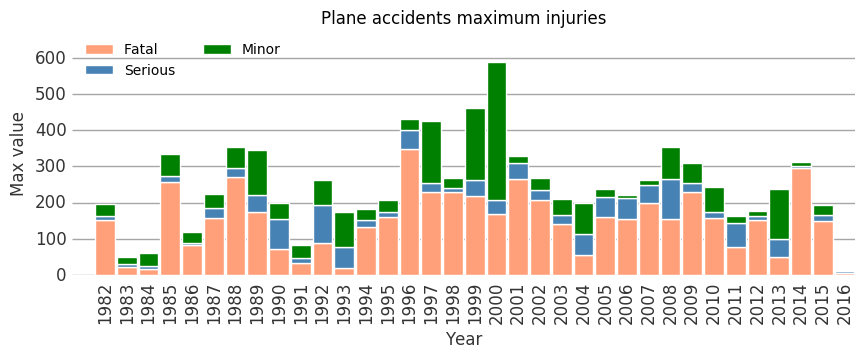

In [58]:
ax = plot_trend(yearly_dig, fields=['Fatal','Serious','Minor'], which='Year')

## Bayesian analysis of the data

In [59]:
import pymc
from pymc import Matplot as mcplt

In [60]:
x = np.floor(yearly_dig.mean()['year']).as_matrix()
y = yearly_dig.max()['fatal'].as_matrix()

In [61]:
def model_fatalities(y=y): 
    s = pymc.DiscreteUniform('s', lower=5, upper=18, value=14)
    e = pymc.Exponential('e', beta=1.)
    l = pymc.Exponential('l', beta=1.)

    @pymc.deterministic(plot=False)
    def m(s=s, e=e, l=l):
        meanval = np.empty(len(y))
        meanval[:s] = e
        meanval[s:] = l 
        return meanval
    D = pymc.Poisson('D', mu=m, value=y, observed=True)
    return locals()

In [62]:
np.random.seed(1234)
MDL = pymc.MCMC(model_fatalities(y=y))

In [63]:
MDL.sample(5e4, 5e3, 2)

 [-----------------100%-----------------] 50000 of 50000 complete in 15.4 sec

In [64]:
MDL.step_method_dict

{<pymc.distributions.new_dist_class.<locals>.new_class 'e' at 0x000001ADC4D505F8>: [<pymc.StepMethods.Metropolis at 0x1adc4d50b00>],
 <pymc.distributions.new_dist_class.<locals>.new_class 's' at 0x000001ADC4D50438>: [<pymc.StepMethods.DiscreteMetropolis at 0x1adc4d50cf8>],
 <pymc.distributions.new_dist_class.<locals>.new_class 'l' at 0x000001ADC4D50278>: [<pymc.StepMethods.Metropolis at 0x1adc4d505c0>]}

In [65]:
early = MDL.stats()['e']['mean']
earlyerr = MDL.stats()['e']['standard deviation']
late = MDL.stats()['l']['mean']
lateerr = MDL.stats()['l']['standard deviation']

spt = MDL.stats()['s']['mean']
spterr = MDL.stats()['s']['standard deviation']

Plotting s
Plotting l
Plotting e


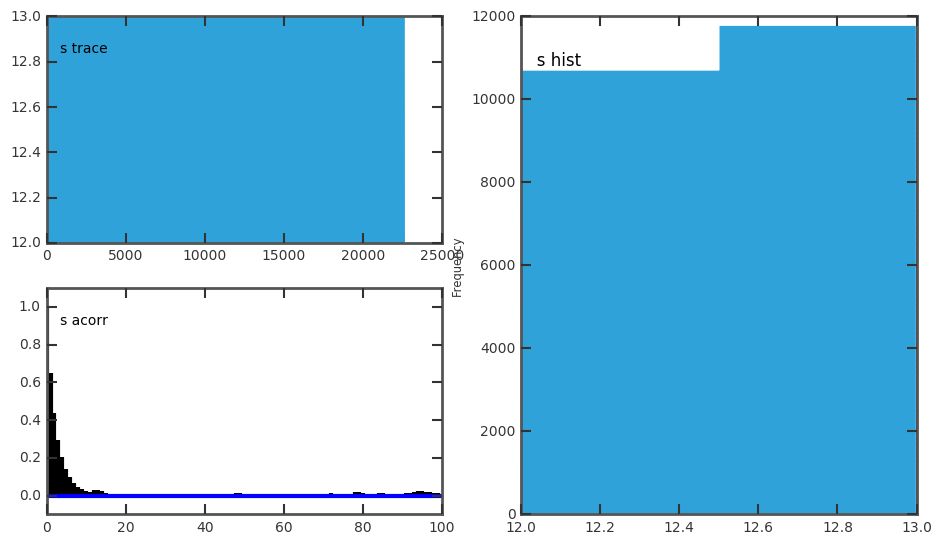

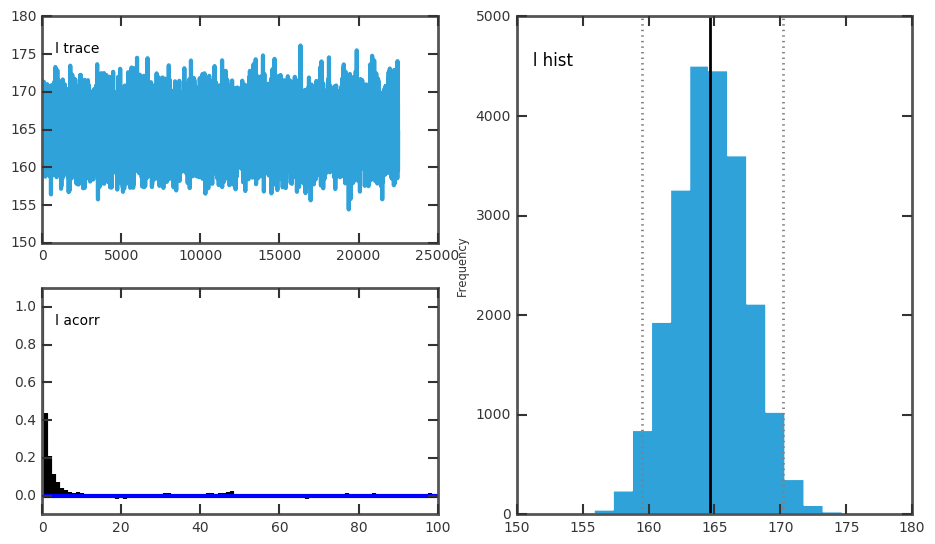

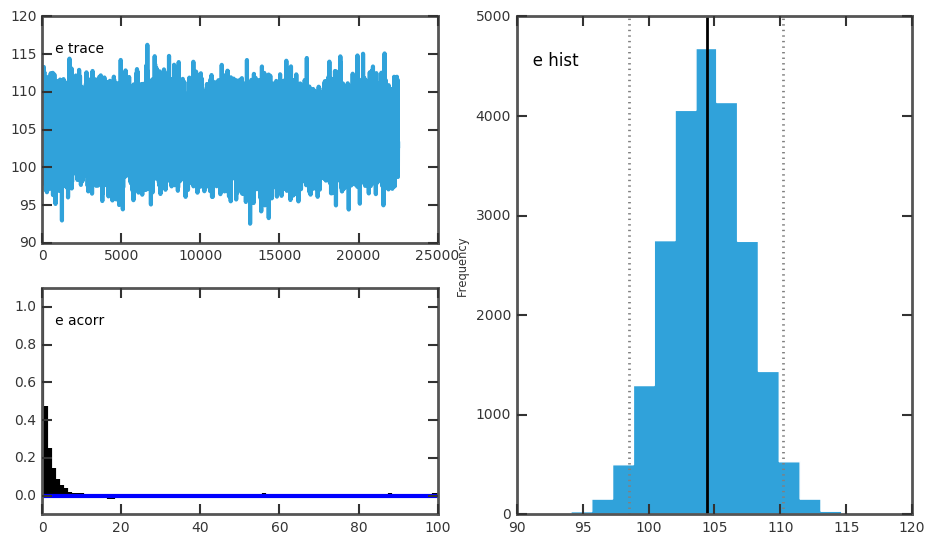

In [66]:
mcplt.plot(MDL)

Plotting l


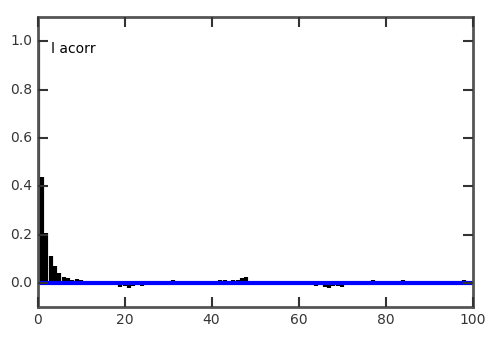

In [67]:
mcplt.autocorrelation(MDL.l)

In [68]:
s = int(np.floor(spt))
print(spt,spterr,x[s])

12.524 0.499423667841 1994.0


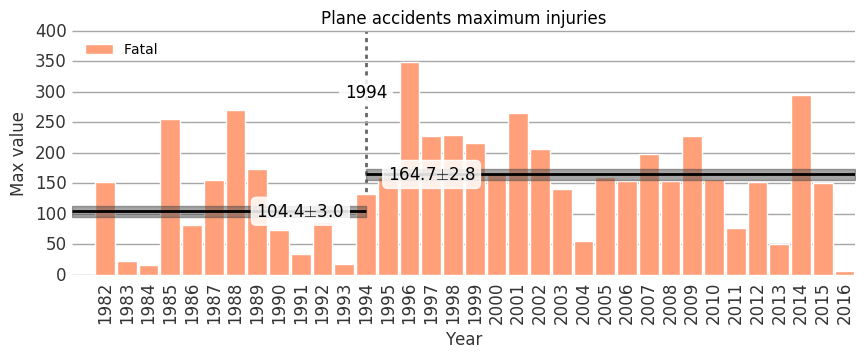

In [69]:
ax = plot_trend(yearly_dig, fields=['Fatal'], which='Year')
ax.plot([x[0]-1.5,x[s]],[early,early], 'k', lw=2,
           zorder=5)
ax.fill_between([x[0]-1.5,x[s]],
                [early-3*earlyerr,early-3*earlyerr],
                [early+3*earlyerr,early+3*earlyerr],
               color='0.3', alpha=0.5, zorder=5)
ax.plot([x[s],x[-1]+0.5],[late,late], 'k', lw=2, zorder=5)
ax.fill_between([x[s],x[-1]+0.5],
                [late-3*lateerr,late-3*lateerr], 
                [late+3*lateerr,late+3*lateerr], 
                color='0.3', alpha=0.5, zorder=5)
ax.axvline(int(x[s]), color='0.4', dashes=(3,3), lw=2)
bbox_args = dict(boxstyle="round", fc="w", alpha=0.85)
ax.annotate('{0:.1f}$\pm${1:.1f}'.format(early, earlyerr), 
            xy=(x[s]-1,early), 
            bbox=bbox_args, ha='right', va='center',
           zorder=5)
ax.annotate('{0:.1f}$\pm${1:.1f}'.format(late, lateerr), 
            xy=(x[s]+1,late), 
            bbox=bbox_args, ha='left',va='center',
           zorder=5)
ax.annotate('{0}'.format(int(x[s])),xy=(int(x[s]),300), 
            bbox=bbox_args, ha='center',va='center',
           zorder=5);

### Monthly

In [70]:
bins = np.arange(1, 12+1, 1 )
monthly_dig = aadata.groupby(np.digitize(aadata.month, bins))

In [71]:
monthly_dig.mean().head()

,lat,long,fatal,serious,minor,uninjured,month,year,decyear
1,35.355070,-91.799283,1.024984,0.351452,0.482369,7.505215,1,1996.595841,1996.637186
2,35.211711,-92.921433,0.890277,0.295262,0.486586,6.861646,2,1996.190641,1996.313377
3,36.439443,-93.719725,0.673851,0.281289,0.428362,6.491056,3,1996.299847,1996.503531
4,37.187038,-93.330245,0.651183,0.304870,0.489868,5.455664,4,1996.292600,1996.579883
5,37.816921,-94.954229,0.671199,0.272957,0.445699,5.194848,5,1996.382683,1996.754983


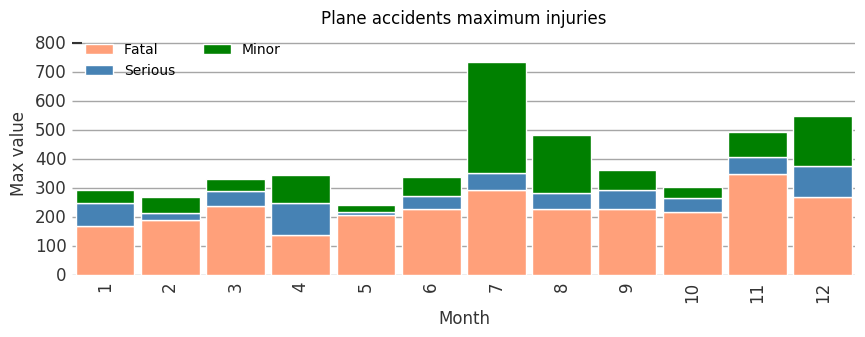

In [72]:
ax = plot_trend(monthly_dig, fields=['Fatal', 'Serious', 'Minor'], which='Month')
ax.set_xlim(0.5,12.5);

### Plotting the coordinates

In [73]:
lats, lons = aadata['lat'].as_matrix(), aadata['long'].as_matrix()

### Cartopy

In [74]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

fig = plt.figure(figsize=(12,10
                         ))
ax = fig.add_axes([0,0,1,1], projection=ccrs.PlateCarree())
ax.stock_img()
ax.scatter(aadata['long'],aadata['lat'] ,
         color='IndianRed', s=aadata['fatal']*2,
         transform=ccrs.Geodetic(),
         )
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,180+1,60))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ImportError: No module named 'cartopy'

### mpl_toolkits - Basemap

In [ ]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(11,10))
ax = fig.add_axes([0,0,1,1])

map = Basemap(projection='cyl', resolution='c')
map.shadedrelief()
#map.drawcoastlines()
#map.drawcountries()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0], 
                  color='grey')
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60), 
                  labels=[0,0,0,1], color='grey')
x, y = map(lons, lats)
map.scatter(x, y, color='IndianRed', s=aadata['fatal']*2);

# Bayesian linear regression

## Getting the climate data

In [75]:
co2_gr = pd.read_csv('data/co2_gr_gl.txt', 
                  delim_whitespace=True,
                 skiprows=62,
                 names=['year', 'rate', 'err'])
co2_now = pd.read_csv('data/co2_annmean_gl.txt', 
                  delim_whitespace=True,
                 skiprows=57,
                 names=['year', 'co2', 'err'])
co2_200 = pd.read_csv('data/siple2.013.dat', 
                  delim_whitespace=True,
                 skiprows=36,
                 names=['depth', 'year', 'co2'])
co2_1000 = pd.read_csv('data/lawdome.smoothed.yr75.dat', 
                  delim_whitespace=True,
                 skiprows=22,
                 names=['year', 'co2'])

In [76]:
co2_200.tail()

,depth,year,co2
20,86.80,1943,307.9
21,81.22,1953,312.7
22,Data,in,the
23,table,were,published
24,CO2,concentrations,are


In [77]:
co2_200 = co2_200[:-3]

In [78]:
print( co2_200['year'].dtype, co2_1000['co2'].dtype, co2_now['co2'].dtype, co2_gr['rate'].dtype) 

object float64 float64 float64


In [79]:
co2_200['year'] = pd.to_numeric(co2_200['year'])
co2_200['co2'] = pd.to_numeric(co2_200['co2'])
co2_200['co2'].dtype,co2_200['year'].dtype

(dtype('float64'), dtype('int64'))

## Starting the analysis

1959


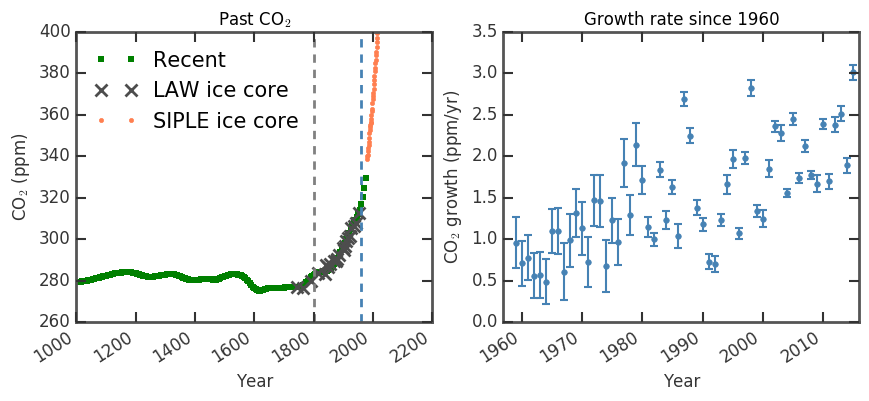

In [80]:
fig,axs = plt.subplots(1,2,figsize=(9,3.5))

ax2 = axs[0]
ax2.errorbar(co2_now['year'], co2_now['co2'], 
           color='Coral',
           ls='None',  
           elinewidth=1,
           capthick=1.5,
           marker='.', 
           ms=6)

ax2.plot(co2_1000['year'], co2_1000['co2'],
            color='Green',
           ls='None',  
           marker='s', mew=0,
           ms=5)
ax2.plot(co2_200['year'], co2_200['co2'],
            color='0.3',
           ls='None', 
           marker='x', mew=2,
           ms=8)
ax2.legend(['Recent', 'LAW ice core', 'SIPLE ice core'],fontsize=15, loc=2)

ax2.axvline(1800, lw=2, color='Gray', dashes=(6,5))

ax2.axvline(co2_gr['year'][0], lw=2, color='SteelBlue', dashes=(6,5))
print(co2_gr['year'][0])

labels = ax2.get_xticklabels()
plt.setp(labels, rotation=33, ha='right')
ax2.set_ylabel('CO$_2$ (ppm)')
ax2.set_xlabel('Year')
ax2.set_title('Past CO$_2$')


ax1 = axs[1]
ax1.errorbar(co2_gr['year'], co2_gr['rate'], 
           yerr=co2_gr['err'],
           color='SteelBlue',
           ls='None',  
           elinewidth=1.5,
           capthick=1.5,
           marker='.',
           ms=8)

labels = ax1.get_xticklabels()
plt.setp(labels, rotation=33, ha='right')
ax1.set_ylabel('CO$_2$ growth (ppm/yr)')
ax1.set_xlabel('Year')
ax1.set_xlim((1957,2016))
ax1.set_title('Growth rate since 1960');

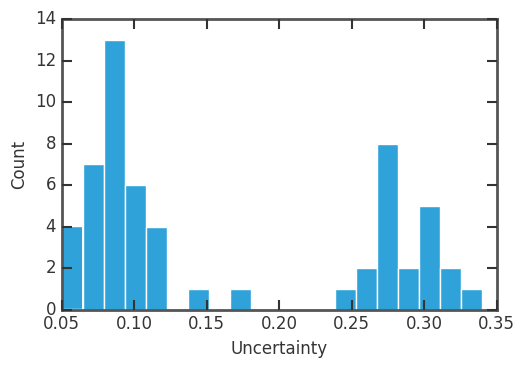

In [81]:
_ = plt.hist(co2_gr['err'], bins=20)
plt.xlabel('Uncertainty')
plt.ylabel('Count');

In [82]:
x = co2_gr['year'].as_matrix()  
y = co2_gr['rate'].as_matrix()
y_error = co2_gr['err'].as_matrix()

In [83]:
def model(x, y): 
    slope = pymc.Normal('slope', 0.1, 1.)
    intercept = pymc.Normal('intercept', -50., 10.)
    @pymc.deterministic(plot=False)
    def linear(x=x, slope=slope, intercept=intercept):
        return x * slope + intercept
    f = pymc.Normal('f', mu=linear, tau=1.0/y_error, value=y, observed=True)
    return locals()

In [84]:
MDL = pymc.MCMC(model(x,y))
MDL.sample(5e5, 5e4, 100)

 [-----------------100%-----------------] 500000 of 500000 complete in 79.0 sec

In [85]:
y_min = MDL.stats()['linear']['quantiles'][2.5]
y_max = MDL.stats()['linear']['quantiles'][97.5]
y_fit = MDL.stats()['linear']['mean']

slope = MDL.stats()['slope']['mean']
slope_err = MDL.stats()['slope']['standard deviation']
intercept = MDL.stats()['intercept']['mean']
intercept_err = MDL.stats()['intercept']['standard deviation']


Plotting slope
Plotting intercept


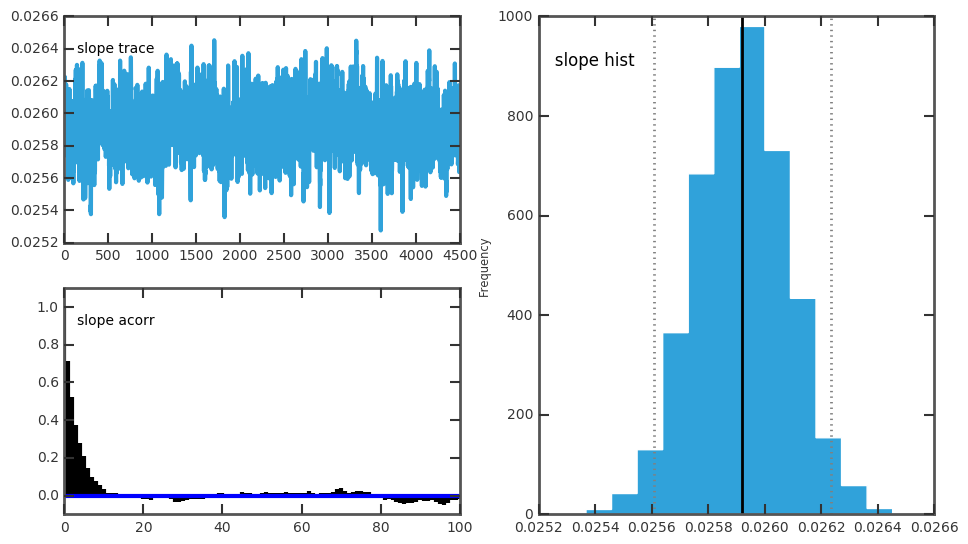

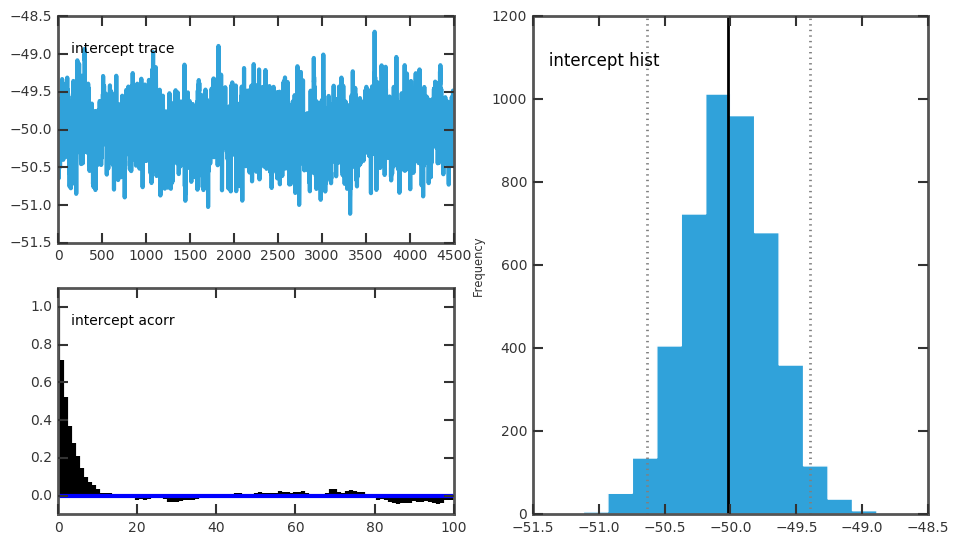

In [86]:
mcplt.plot(MDL)

In [87]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
ols_results = smf.ols("rate ~ year", co2_gr).fit()

In [88]:
prstd, iv_l, iv_u = wls_prediction_std(ols_results)
ols_params = np.flipud(ols_results.params)
ols_err = np.flipud(np.diag(ols_results.cov_params())**.5)

In [89]:
print('OLS: slope:{0:.3f}, intercept:{1:.2f}'.format(*ols_params))
print('Bay: slope:{0:.3f}, intercept:{1:.2f}'.format(slope, intercept))

OLS: slope:0.027, intercept:-51.81
Bay: slope:0.026, intercept:-50.01


In [90]:
ols_results.conf_int(alpha=0.05)

,0,1
Intercept,-66.531103,-37.092365
year,0.019425,0.034240


In [91]:
MDL.stats(['intercept','slope'])

{'intercept': {'95% HPD interval': array([-50.63233078, -49.39395034]),
  'mc error': 0.011017805178696665,
  'mean': -50.013774260140366,
  'n': 4500,
  'quantiles': {2.5: -50.630818101815244,
   25: -50.231195897166764,
   50: -50.016509600718216,
   75: -49.795083575418737,
   97.5: -49.391214451128555},
  'standard deviation': 0.32020671947198903},
 'slope': {'95% HPD interval': array([ 0.02560589,  0.02623452]),
  'mc error': 5.6240712105452008e-06,
  'mean': 0.025918381799316739,
  'n': 4500,
  'quantiles': {2.5: 0.025599897361890521,
   25: 0.025808359459155772,
   50: 0.025919072959172007,
   75: 0.026027530226023589,
   97.5: 0.026232363540277817},
  'standard deviation': 0.00016229865045853001}}

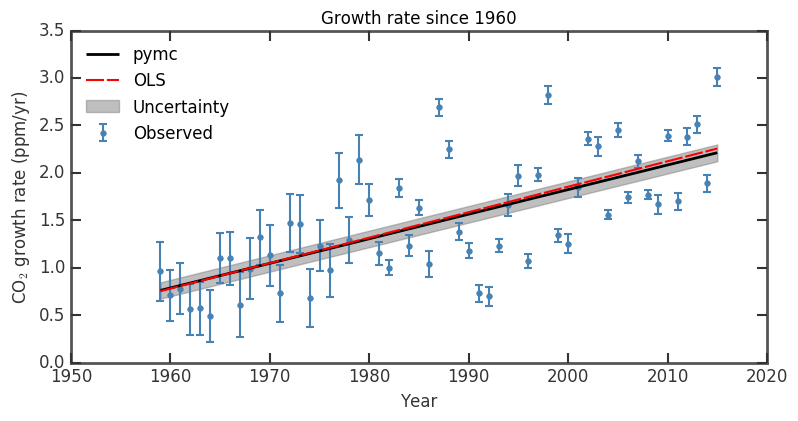

In [92]:
plt.figure(figsize=(8,4))
plt.title('Growth rate since 1960');
plt.errorbar(x,y,yerr=y_error,             
        color='SteelBlue', ls='None',  
        elinewidth=1.5, capthick=1.5,
        marker='.', ms=8, 
        label='Observed')
plt.xlabel('Year')
plt.ylabel('CO$_2$ growth rate (ppm/yr)')
plt.plot(x, y_fit, 
         'k', lw=2, label='pymc')
plt.fill_between(x, y_min, y_max, 
                 color='0.5', alpha=0.5, 
                 label='Uncertainty')
plt.plot([x.min(), x.max()], 
         [ols_results.fittedvalues.min(), ols_results.fittedvalues.max()], 
         'r', dashes=(13,2), lw=1.5, label='OLS', zorder=32)
plt.legend(loc=2, numpoints=1, fontsize=12);